<a href='https://www.latos.ai'> <img src='../logo_latos.jpeg' style="width: 200px;" align="right"/></a>
*Esse notebook faz parte do curso de [Python e Ciência de Dados para a Indústria](https://www.latos.ai/academy/python-e-ciencia-de-dados) da [Latos Academy](https://www.latos.ai).*

Latos© copyright 2022. All Rights Reserved.

# Aprendizado de máquina na indústria -  Base de dados Power Plant

In [1]:
from pathlib import Path
import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn import metrics

my_figsize = (15, 8)

In [2]:
root_dir = Path.cwd().parents[1]
data_dir = root_dir / 'data'


data = pd.read_excel(data_dir / 'powerplant.xlsx')

In [4]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [6]:
data.to_csv('clean', index=False)

## Pré-processamento

### Remoção de outliers

In [4]:
cols = ['AT', 'V', 'AP', 'RH', 'PE']

Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

IQR

AT    12.2100
V     24.8000
AP     8.1600
RH    21.5025
PE    28.6800
dtype: float64

In [5]:
data[cols] < (Q1 - 1.5 * IQR)

,AT,V,AP,RH,PE
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
9563,False,False,False,False,False
9564,False,False,False,False,False
9565,False,False,False,False,False
9566,False,False,False,False,False


In [6]:
np.sum(data[cols] < (Q1 - 1.5 * IQR))

AT     0
V      0
AP    15
RH    12
PE     0
dtype: int64

In [7]:
np.sum(data[cols] > (Q3 + 1.5 * IQR))

AT     0
V      0
AP    73
RH     0
PE     0
dtype: int64

In [8]:
ind_keep = ~((data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR)))

ind_keep = ind_keep.all(axis=1)
data_clean = data[ind_keep]
data_clean

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


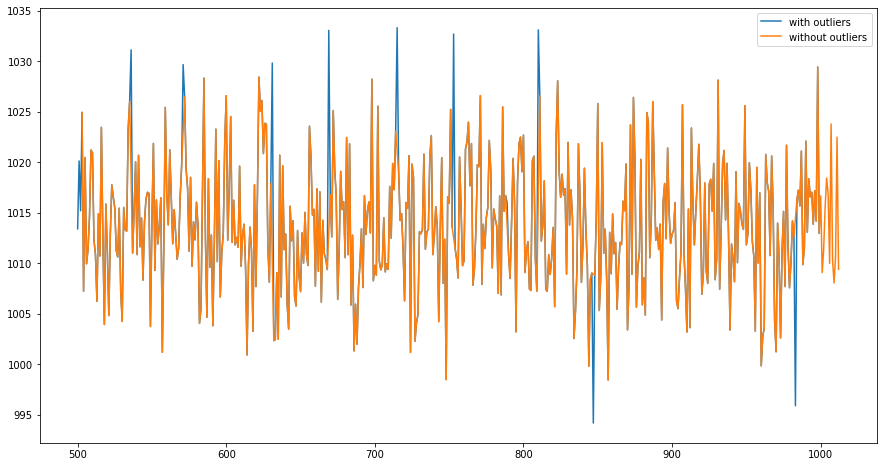

In [9]:
plt.figure(figsize=my_figsize)
plt.plot(data['AP'][500:1000])
plt.plot(data_clean['AP'][500:1000])
plt.legend(['with outliers', 'without outliers'])

### Escalonamento

In [10]:
from sklearn.preprocessing import StandardScaler

X = data_clean.iloc[:, :-1]
y = data_clean.iloc[:, -1]

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[-0.64089601, -0.99629561,  1.91454789, -0.01045211],
       [ 0.73517931,  0.67289863,  1.20806604, -0.97880806],
       [-1.96715256, -1.18211158, -0.17334265,  1.293289  ],
       ...,
       [ 1.56190167,  1.56812214, -0.04011034, -2.53202625],
       [ 0.64092758,  1.18389252,  0.12467699, -0.75132345],
       [ 0.25314902,  0.63825497,  0.7154571 , -0.3747024 ]])

<AxesSubplot:>

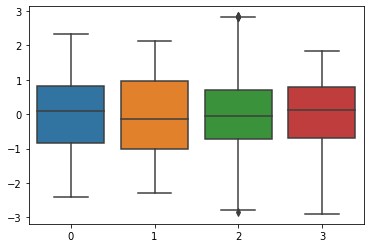

In [11]:
sns.boxplot(data=X_scaled)

## Aprendizado de Máquina

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, 
                                                    random_state=101)

In [13]:
# regressão linear
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

lm_prediction = lm.predict(X_test)
metrics.r2_score(lm_prediction, y_test)

0.9202820051690309

In [14]:
lm.coef_

array([-14.75220011,  -2.93428395,   0.37224887,  -2.31501672])

In [15]:
# árvores de decisão
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

dtree_prediction = dtree.predict(X_test)
metrics.r2_score(dtree_prediction, y_test)

0.932912052669213

In [16]:
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor()
rforest.fit(X_train, y_train)

rforest_prediction = rforest.predict(X_test)
metrics.r2_score(rforest_prediction, y_test)

0.9550289551470351

In [17]:
metrics.mean_absolute_error(rforest_prediction, y_test)

2.462549384019709

In [18]:
mse = metrics.mean_squared_error(rforest_prediction, y_test)
np.sqrt(mse)

3.574180935631769

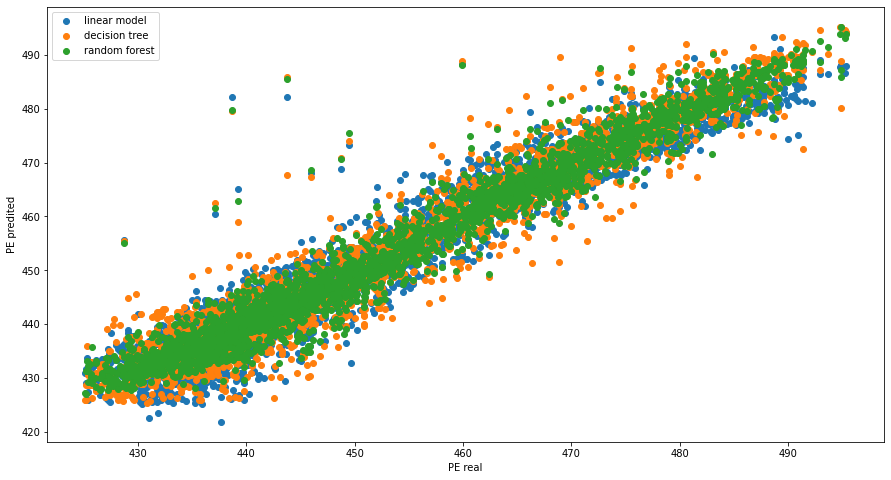

In [19]:
plt.figure(figsize=my_figsize)
plt.scatter(y_test, lm_prediction)
plt.scatter(y_test, dtree_prediction)
plt.scatter(y_test, rforest_prediction)
plt.xlabel('PE real')
plt.ylabel('PE predited')
plt.legend(['linear model', 'decision tree', 'random forest'])
plt.show()